In [32]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8')
%matplotlib inline

class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit

    Keep implementations simple and readable; tests and visualization code will
    use these methods once implemented.
    """
    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids.

        TODO (student):
        - Randomly select `n_clusters` distinct points from X as initial centroids.
        - Return an array of shape (n_clusters, n_features).
        Hint: Use np.random.choice to pick indices.
        """
        np.random.seed(self.random_state)
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[random_indices]

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid.

        TODO (student):
        - Compute distance from each point to each centroid (Euclidean)
        - Return an integer array of shape (n_samples,) with cluster labels
        Hint: np.linalg.norm with axis manipulation or broadcasting helps here.
        """
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        """Recompute centroids as the mean of points assigned to each cluster.

        TODO (student):
        - For each cluster id in 0..n_clusters-1 compute the mean of points
          assigned to that cluster. If a cluster has no points, consider reinitializing
          its centroid (or leave unchanged) — discuss in your report.
        - Return an array of shape (n_clusters, n_features).
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                # If cluster is empty, keep the old centroid
                new_centroids[i] = self.centroids[i]
        return new_centroids

    def fit(self, X):
        """Run K-means until convergence or max_iters.

        TODO (student):
        - Initialize centroids
        - Loop: assign clusters, update centroids
        - Stop early if centroids do not change (or change below a tiny threshold)
        - Store final labels in self.labels and centroids in self.centroids
        - Return self
        """
        self.centroids = self._initialize_centroids(X)
        
        for iteration in range(self.max_iters):
            old_centroids = self.centroids.copy()
            
            # Assign clusters
            self.labels = self._assign_clusters(X)
            
            # Update centroids
            self.centroids = self._update_centroids(X, self.labels)
            
            # Check for convergence
            if np.allclose(old_centroids, self.centroids, atol=1e-6):
                print(f"Converged after {iteration + 1} iterations")
                break
        
        return self

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids.

        Implementation may call _assign_clusters but should error if centroids
        are not yet initialized (i.e., if fit wasn't called).
        """
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)

# Bank Customer Segmentation Analysis - Student Exercise

**IMPORTANT: Please run all cells in order from top to bottom.**
**Do not skip any cells, as each cell depends on previous definitions.**

In this lab, you will implement customer segmentation using K-means clustering. You'll learn how to:
1. Preprocess data for clustering
2. Perform and visualize dimensionality reduction
3. Implement K-means clustering from scratch
4. Evaluate clustering results

Follow the instructions in each section and fill in the code where indicated.

In [33]:
# Load Data and Preprocess
def load_data(filepath):
    pass

#================ FOR PCA Dimensionality reduction =========
# Feature Correlation Matrix
def plot_correlation_matrix(df, features):
    """Create correlation heatmap for the dataset features."""
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()
    return correlation_matrix

# Apply PCA for Dimensionality Reduction
def apply_pca(x, n_components=2):
    """Apply PCA for dimensionality reduction with visualization."""
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(x)
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot explained variance ratio
    if n_components == 2:
        explained_variance = pca.explained_variance_ratio_
        components = [f'PC{i+1}' for i in range(len(explained_variance))]
        
        axes[0].bar(components, explained_variance, color='skyblue', alpha=0.7)
        axes[0].plot(components, explained_variance, 'ro-', linewidth=2)
        axes[0].set_title('Explained Variance by Principal Component')
        axes[0].set_ylabel('Explained Variance Ratio')
        axes[0].set_xlabel('Principal Component')
        
        # Add cumulative variance
        cumulative_variance = np.cumsum(explained_variance)
        axes[0].twinx().plot(components, cumulative_variance, 'go-', linewidth=2, label='Cumulative')
        axes[0].twinx().set_ylabel('Cumulative Variance Ratio')
        axes[0].legend(['Individual', 'Cumulative'])
    
    # Plot data distribution in PCA space
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c='lightblue', edgecolors='black')
    axes[1].set_xlabel('First Principal Component')
    axes[1].set_ylabel('Second Principal Component')
    axes[1].set_title('Data Distribution in PCA Space')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return X_pca, pca

#================ FOR K-Means ===============================
# Find Optimal Clusters for KMeans (Elbow Method) 
def find_optimal_clusters(x, max_clusters=10):
    """Find optimal number of clusters using elbow method and silhouette analysis."""
    from sklearn.cluster import KMeans
    
    K = range(1, max_clusters + 1)
    inertias = []
    silhouette_scores = []
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(x)
        inertias.append(kmeans.inertia_)
        
        if k > 1:  # Silhouette score requires at least 2 clusters
            score = silhouette_score(x, kmeans.labels_)
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(0)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Elbow curve
    axes[0].plot(K, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia (Within-cluster sum of squares)')
    axes[0].set_title('Elbow Method for Optimal k')
    axes[0].grid(True, alpha=0.3)
    
    # Silhouette scores
    axes[1].plot(K[1:], silhouette_scores[1:], 'ro-', linewidth=2, markersize=8)
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Score Analysis')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k (elbow point and max silhouette)
    optimal_k_elbow = find_elbow_point(inertias)
    optimal_k_silhouette = np.argmax(silhouette_scores[1:]) + 2
    
    print(f"Optimal k (Elbow method): {optimal_k_elbow}")
    print(f"Optimal k (Silhouette): {optimal_k_silhouette}")
    
    return K, inertias, silhouette_scores

def find_elbow_point(inertias):
    """Find the elbow point using the second derivative method."""
    if len(inertias) < 3:
        return 2
    
    # Calculate second derivative
    second_diff = []
    for i in range(1, len(inertias) - 1):
        diff = (inertias[i-1] - inertias[i]) - (inertias[i] - inertias[i+1])
        second_diff.append(diff)
    
    if second_diff:
        elbow_idx = np.argmax(second_diff) + 1
        return elbow_idx + 1  # +1 because we start from k=1
    return 2

# Perform KMeans Clustering 
# Change None to the number of n_clusters value from the elbow method
def perform_kmeans_clustering(x, n_clusters=None):
    pass

#================ FOR Agglomerative ===============================
# Perform Agglomerative Clustering 
def perform_agglomerative_clustering(x, n_clusters=None):
    """Perform Agglomerative Clustering."""
    from sklearn.cluster import AgglomerativeClustering
    
    if n_clusters is None:
        n_clusters = 3  # Default value
    
    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    labels = agg_clustering.fit_predict(x)
    
    return labels, agg_clustering

#================FOR Dendrogram===============================
# Get Linkages for Dendrogram
def get_linkages(x):
    """Compute linkage for dendrogram."""
    from scipy.cluster.hierarchy import linkage
    return linkage(x, method='ward')

# Plot Dendrogram
def plot_dendrogram(linked):
    """Plot dendrogram."""
    from scipy.cluster.hierarchy import dendrogram
    
    plt.figure(figsize=(12, 6))
    dendrogram(linked)
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Sample Index')
    plt.ylabel('Distance')
    plt.grid(True, alpha=0.3)
    plt.show()

## 1. Data Loading and Preprocessing

First, complete the data preprocessing function below. You need to:
1. Load the data
2. Handle categorical variables
3. Scale numerical features

Data shape: (45211, 9)
KMeansClustering class is available.

=== Feature Correlation Analysis ===


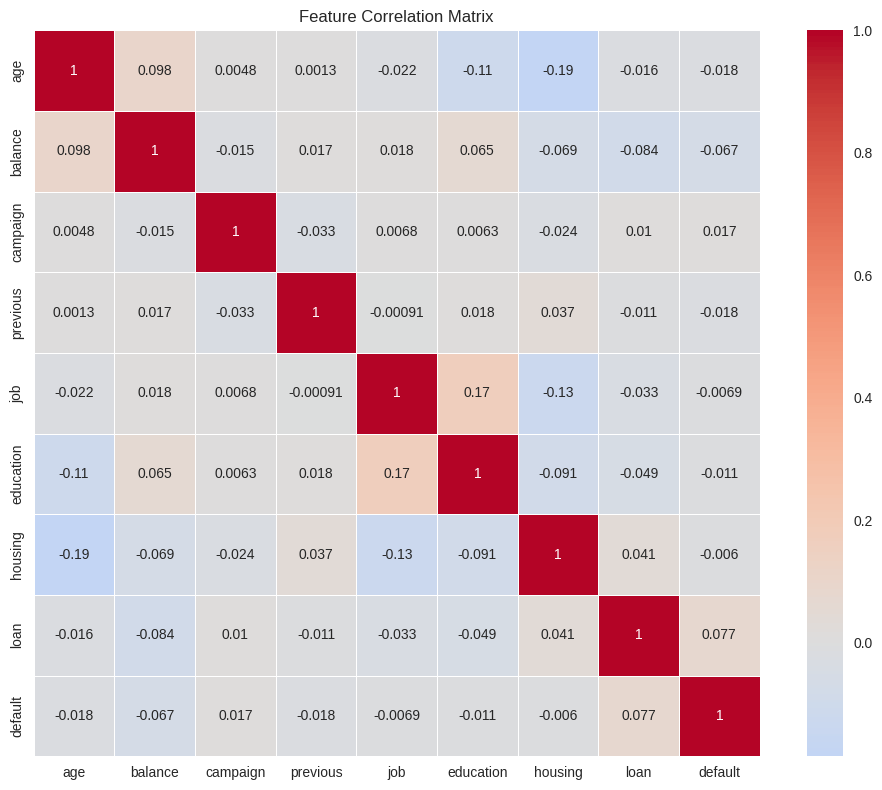


=== PCA Dimensionality Reduction ===


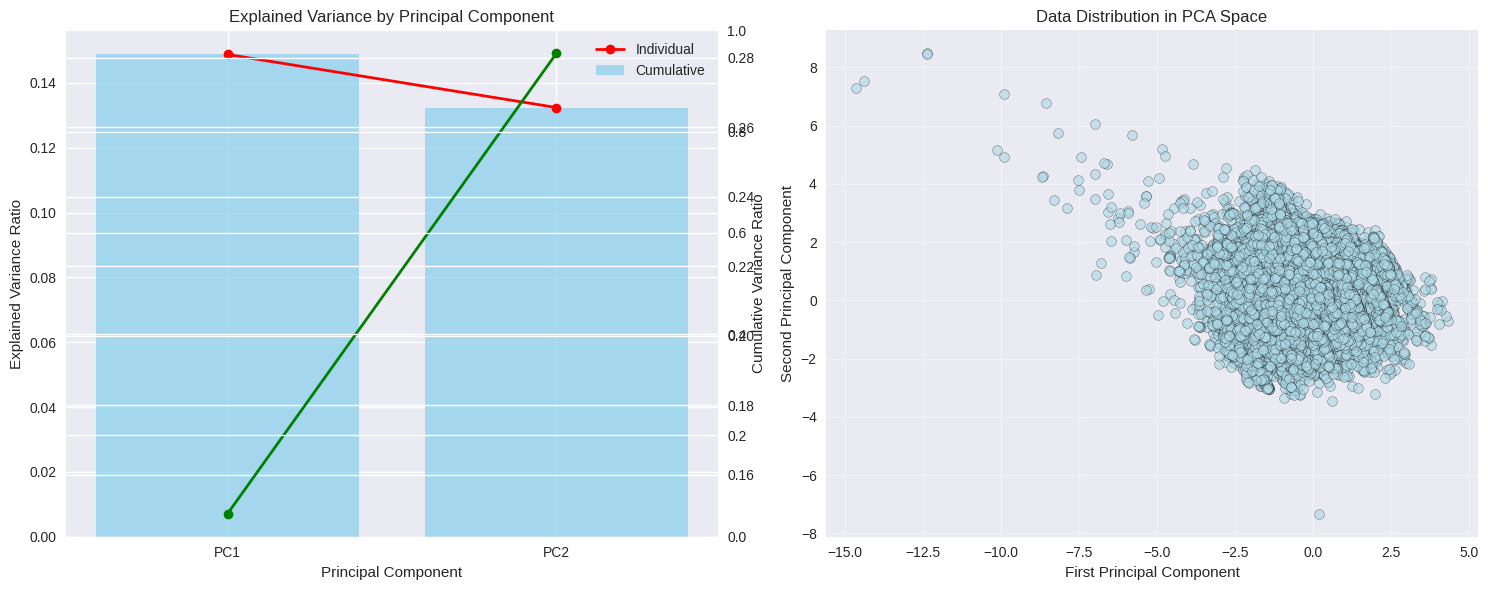

Shape after PCA: (45211, 2)

Explained variance by PC1: 0.149 (14.9%)
Explained variance by PC2: 0.132 (13.2%)
Cumulative explained variance: 0.281 (28.1%)

=== Optimal Number of Clusters Analysis ===


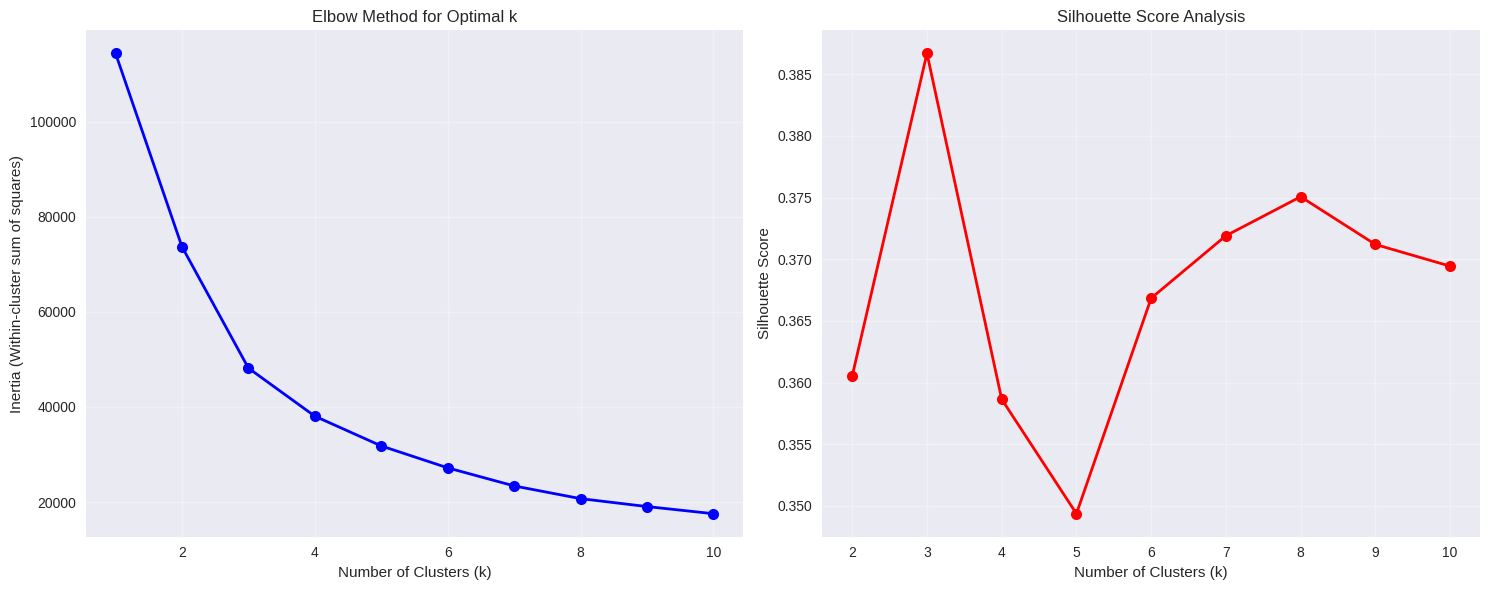

Optimal k (Elbow method): 3
Optimal k (Silhouette): 3

=== Final Clustering Analysis ===
Using k=3 based on silhouette analysis
Converged after 27 iterations

Final Clustering Evaluation:
Optimal k: 3
Inertia: 48179.64
Silhouette Score: 0.387

=== Comprehensive Cluster Analysis ===

Final Clustering Evaluation:
Optimal k: 3
Inertia: 48179.64
Silhouette Score: 0.387

=== Comprehensive Cluster Analysis ===


/tmp/ipykernel_31587/1227248375.py:75: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(silhouette_data, labels=cluster_labels, patch_artist=True)


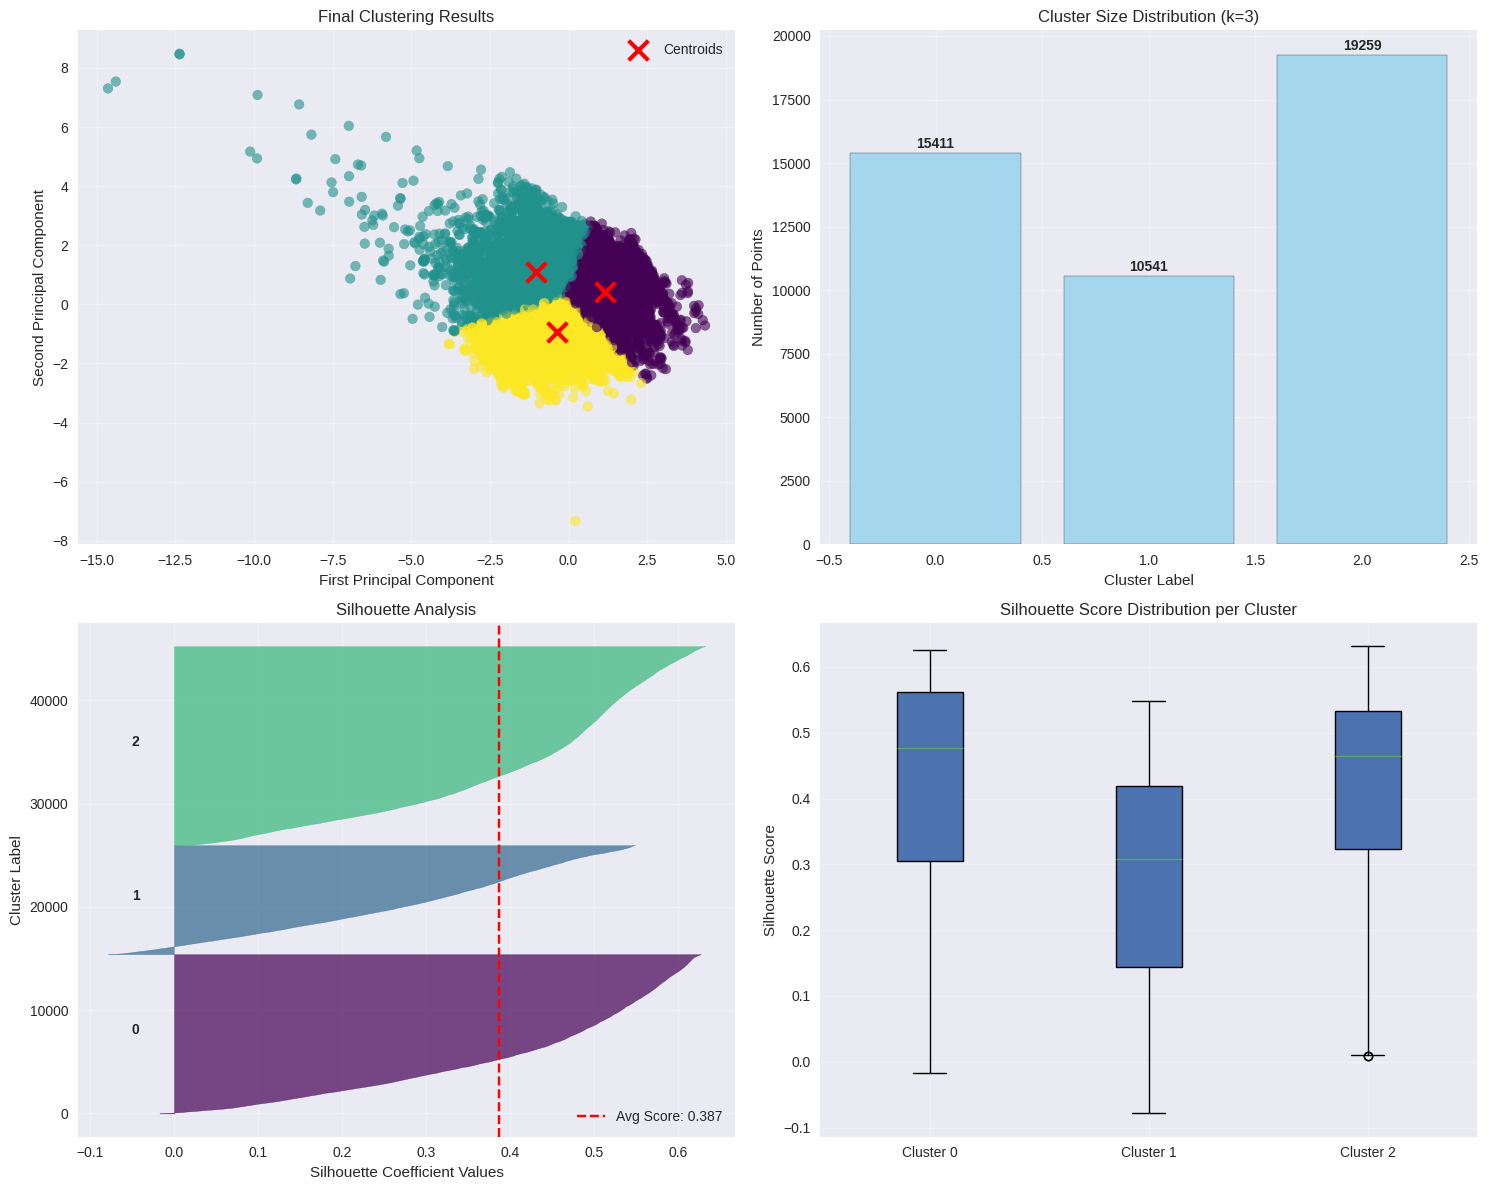


=== Comparison with sklearn KMeans ===
Sklearn KMeans Silhouette Score: 0.387
Custom KMeans Silhouette Score: 0.387
Sklearn KMeans Silhouette Score: 0.387
Custom KMeans Silhouette Score: 0.387


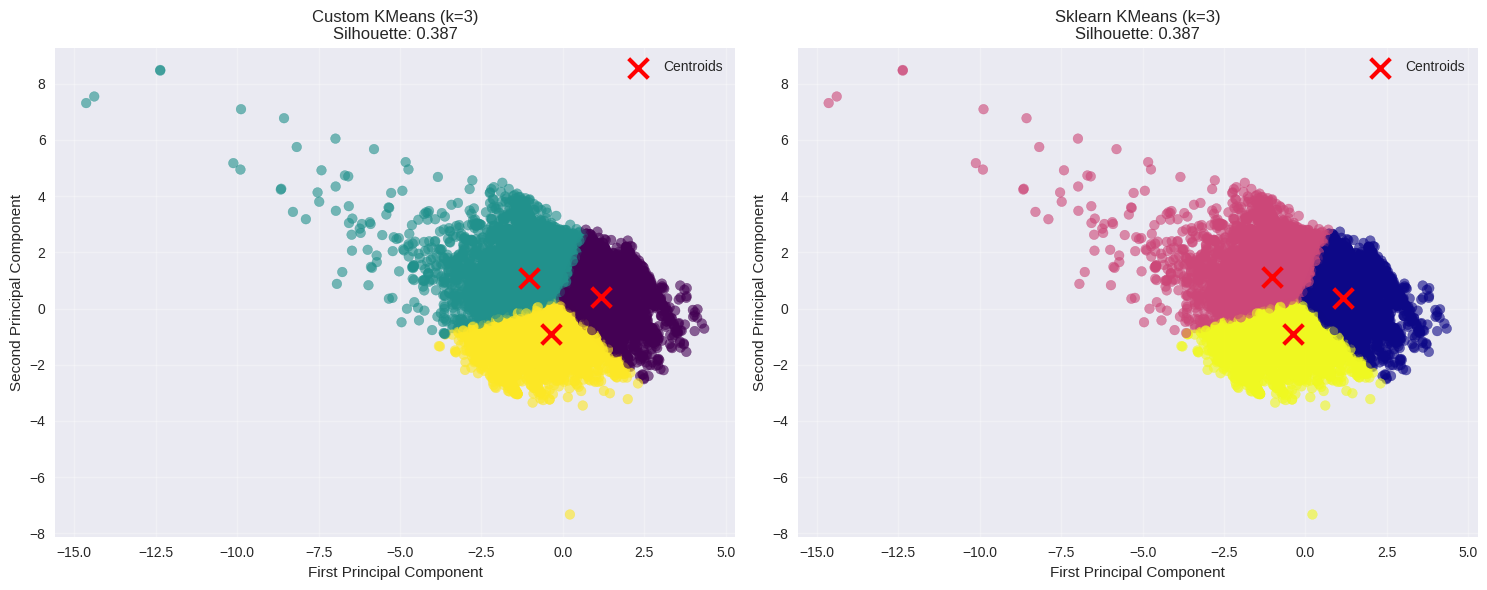

In [34]:
def load_data(filepath):
    """Load and preprocess the bank marketing dataset.
    
    TODO:
    1. Load the CSV file (hint: it uses semicolon separator)
    2. Convert categorical columns to numerical using LabelEncoder
    3. Scale the features using StandardScaler
    """
    # Load data
    df = pd.read_csv(filepath, sep=';')
    
    # List of categorical columns to encode
    categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 
                       'loan', 'contact', 'month', 'poutcome', 'y']
    
    # Apply label encoding to categorical columns
    le = LabelEncoder()
    for col in categorical_cols:
        df[col] = le.fit_transform(df[col].astype(str))
    
    # Select features for clustering
    features = ['age', 'balance', 'campaign', 'previous', 'job', 'education', 
               'housing', 'loan', 'default']
    X = df[features].values
    
    # Scale the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, df

# Load and preprocess the data
X_scaled, data = load_data('bank-full.csv')
print("Data shape:", X_scaled.shape)

# Check if KMeansClustering class is available
try:
    KMeansClustering
    print("KMeansClustering class is available.")
except NameError:
    print("ERROR: KMeansClustering class is not defined. Please run the first cell that contains the class definition.")
    print("The KMeansClustering class must be executed before this cell.")
    raise

# Plot correlation matrix for the original features
features = ['age', 'balance', 'campaign', 'previous', 'job', 'education', 'housing', 'loan', 'default']
print("\n=== Feature Correlation Analysis ===")
correlation_matrix = plot_correlation_matrix(data, features)

# Apply PCA
print("\n=== PCA Dimensionality Reduction ===")
X_pca, pca_model = apply_pca(X_scaled, n_components=2)
print("Shape after PCA:", X_pca.shape)

# Explained variance information
explained_variance = pca_model.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
print(f"\nExplained variance by PC1: {explained_variance[0]:.3f} ({explained_variance[0]*100:.1f}%)")
print(f"Explained variance by PC2: {explained_variance[1]:.3f} ({explained_variance[1]*100:.1f}%)")
print(f"Cumulative explained variance: {cumulative_variance[1]:.3f} ({cumulative_variance[1]*100:.1f}%)")

# Find optimal number of clusters
print("\n=== Optimal Number of Clusters Analysis ===")
K_range, inertias, silhouette_scores = find_optimal_clusters(X_pca, max_clusters=10)

# Apply final clustering using the implemented KMeans class
print("\n=== Final Clustering Analysis ===")
optimal_k = np.argmax(silhouette_scores[1:]) + 2  # Use silhouette score to determine optimal k
print(f"Using k={optimal_k} based on silhouette analysis")

kmeans = KMeansClustering(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_pca)

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette_avg = silhouette_score(X_pca, kmeans.labels)

print(f"\nFinal Clustering Evaluation:")
print(f"Optimal k: {optimal_k}")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette_avg:.3f}")

# Create comprehensive cluster analysis
print("\n=== Comprehensive Cluster Analysis ===")
plot_cluster_analysis(X_pca, kmeans.labels, kmeans.centroids, kmeans)

# Additional analysis: Compare with sklearn's KMeans
print("\n=== Comparison with sklearn KMeans ===")
from sklearn.cluster import KMeans
sklearn_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
sklearn_labels = sklearn_kmeans.fit_predict(X_pca)
sklearn_silhouette = silhouette_score(X_pca, sklearn_labels)

print(f"Sklearn KMeans Silhouette Score: {sklearn_silhouette:.3f}")
print(f"Custom KMeans Silhouette Score: {silhouette_avg:.3f}")

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Custom KMeans results
axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis', alpha=0.6)
axes[0].scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], 
                c='red', marker='x', s=200, linewidth=3, label='Centroids')
axes[0].set_title(f'Custom KMeans (k={optimal_k})\nSilhouette: {silhouette_avg:.3f}')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sklearn KMeans results
axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=sklearn_labels, cmap='plasma', alpha=0.6)
axes[1].scatter(sklearn_kmeans.cluster_centers_[:, 0], sklearn_kmeans.cluster_centers_[:, 1], 
                c='red', marker='x', s=200, linewidth=3, label='Centroids')
axes[1].set_title(f'Sklearn KMeans (k={optimal_k})\nSilhouette: {sklearn_silhouette:.3f}')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [35]:
class KMeansClustering:
    """Minimal K-means skeleton for students to implement.

    Students should implement the core methods below:
    - _initialize_centroids
    - _assign_clusters
    - _update_centroids
    - fit

    Keep implementations simple and readable; tests and visualization code will
    use these methods once implemented.
    """
    def __init__(self, n_clusters=3, max_iters=100, random_state=42):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.random_state = random_state
        self.centroids = None
        self.labels = None

    def _initialize_centroids(self, X):
        """Initialize centroids.

        TODO (student):
        - Randomly select `n_clusters` distinct points from X as initial centroids.
        - Return an array of shape (n_clusters, n_features).
        Hint: Use np.random.choice to pick indices.
        """
        np.random.seed(self.random_state)
        random_indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[random_indices]

    def _assign_clusters(self, X):
        """Assign each sample in X to the nearest centroid.

        TODO (student):
        - Compute distance from each point to each centroid (Euclidean)
        - Return an integer array of shape (n_samples,) with cluster labels
        Hint: np.linalg.norm with axis manipulation or broadcasting helps here.
        """
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

    def _update_centroids(self, X, labels):
        """Recompute centroids as the mean of points assigned to each cluster.

        TODO (student):
        - For each cluster id in 0..n_clusters-1 compute the mean of points
          assigned to that cluster. If a cluster has no points, consider reinitializing
          its centroid (or leave unchanged) — discuss in your report.
        - Return an array of shape (n_clusters, n_features).
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                # If cluster is empty, keep the old centroid
                new_centroids[i] = self.centroids[i]
        return new_centroids

    def fit(self, X):
        """Run K-means until convergence or max_iters.

        TODO (student):
        - Initialize centroids
        - Loop: assign clusters, update centroids
        - Stop early if centroids do not change (or change below a tiny threshold)
        - Store final labels in self.labels and centroids in self.centroids
        - Return self
        """
        self.centroids = self._initialize_centroids(X)
        
        for iteration in range(self.max_iters):
            old_centroids = self.centroids.copy()
            
            # Assign clusters
            self.labels = self._assign_clusters(X)
            
            # Update centroids
            self.centroids = self._update_centroids(X, self.labels)
            
            # Check for convergence
            if np.allclose(old_centroids, self.centroids, atol=1e-6):
                print(f"Converged after {iteration + 1} iterations")
                break
        
        return self

    def predict(self, X):
        """Assign cluster labels to X using the learned centroids.

        Implementation may call _assign_clusters but should error if centroids
        are not yet initialized (i.e., if fit wasn't called).
        """
        if self.centroids is None:
            raise ValueError("Model has not been fitted yet. Call fit(X) first.")
        return self._assign_clusters(X)


## 2. Dimensionality Reduction

Before clustering, we often reduce the dimensionality of our data for better visualization and performance. Implement PCA below:

PCA was already applied in the main execution. Using existing X_pca.
Type of X_pca: <class 'numpy.ndarray'>
X_pca is not a tuple, using directly
Shape after PCA: (45211, 2)


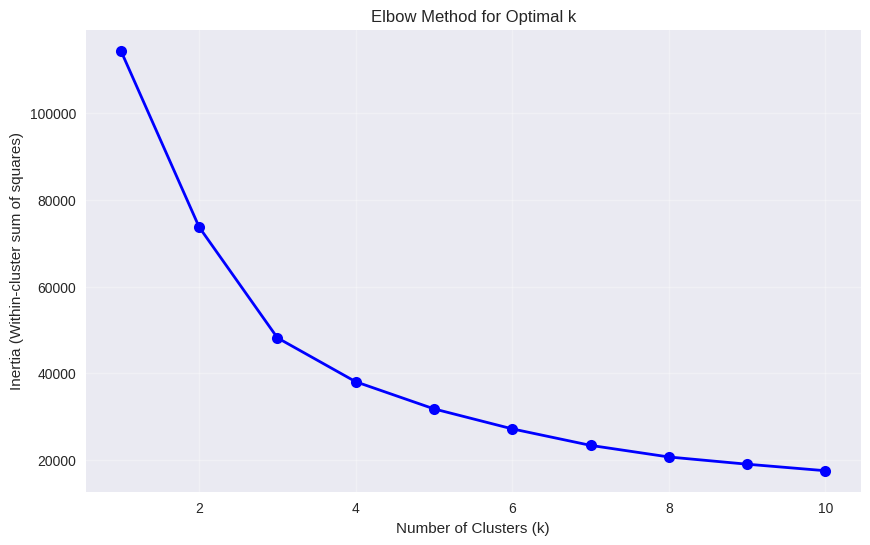

Converged after 27 iterations


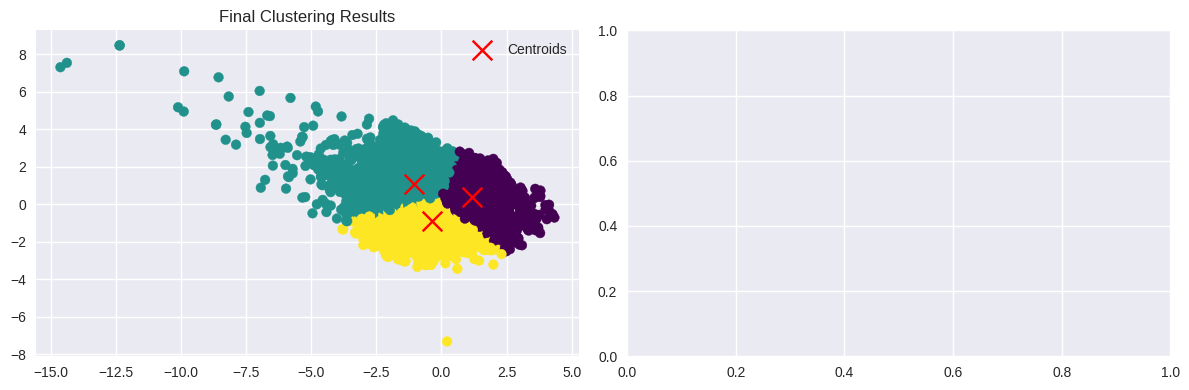


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


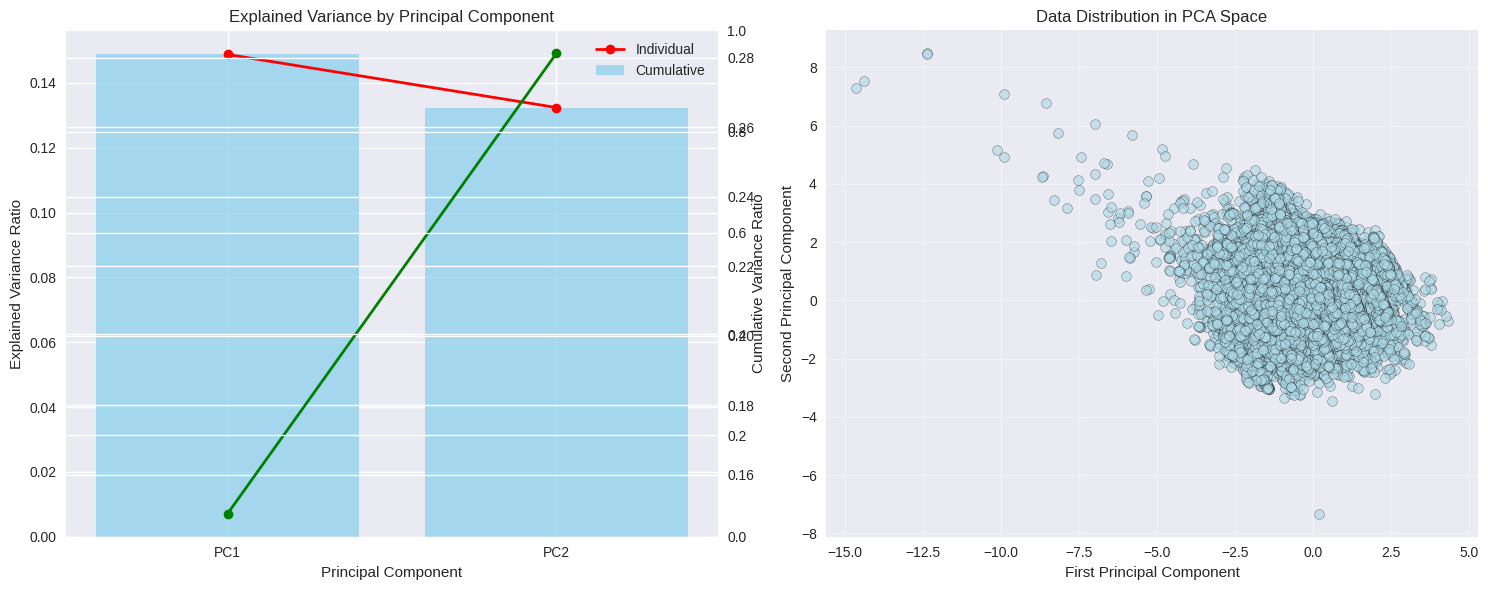

Shape after PCA: (45211, 2)


In [36]:
def apply_pca(X, n_components=2):
    """Apply PCA for dimensionality reduction.
    
    TODO:
    1. Initialize and fit PCA
    2. Transform the data
    3. Create visualizations to understand:
       - Explained variance ratio
       - Cumulative explained variance
       - Data distribution in 2D
    """
    # Your code here:
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    
    # TODO: Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot explained variance
    explained_variance = pca.explained_variance_ratio_
    components = [f'PC{i+1}' for i in range(len(explained_variance))]
    
    axes[0].bar(components, explained_variance, color='skyblue', alpha=0.7)
    axes[0].plot(components, explained_variance, 'ro-', linewidth=2)
    axes[0].set_title('Explained Variance by Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_xlabel('Principal Component')
    
    # Add cumulative variance
    cumulative_variance = np.cumsum(explained_variance)
    axes[0].twinx().plot(components, cumulative_variance, 'go-', linewidth=2, label='Cumulative')
    axes[0].twinx().set_ylabel('Cumulative Variance Ratio')
    axes[0].legend(['Individual', 'Cumulative'])
    
    # Plot data in 2D
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c='lightblue', edgecolors='black')
    axes[1].set_xlabel('First Principal Component')
    axes[1].set_ylabel('Second Principal Component')
    axes[1].set_title('Data Distribution in PCA Space')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return X_pca  # Return only the transformed data, not the tuple

# Apply PCA - Skip this since PCA was already applied in the main execution cell
print("PCA was already applied in the main execution. Using existing X_pca.")

# Debug: Check what type X_pca is
print(f"Type of X_pca: {type(X_pca)}")
if isinstance(X_pca, tuple):
    print(f"X_pca is a tuple with length: {len(X_pca)}")
    print("Using first element of tuple as X_pca_data")
    X_pca_data = X_pca[0]
else:
    print("X_pca is not a tuple, using directly")
    X_pca_data = X_pca

print("Shape after PCA:", X_pca_data.shape)

# Plot elbow curve - Use the existing X_pca from main execution
inertias = plot_elbow_curve(X_pca_data)

# Apply final clustering with custom KMeans
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca_data)

# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca_data[:, 0], X_pca_data[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], 
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# Plot evaluation metrics
plt.subplot(1, 2, 2)
# Your code here: Add relevant evaluation metric plots

plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca_data, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca_data, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

# Apply PCA
X_pca = apply_pca(X_scaled)
print("Shape after PCA:", X_pca.shape)

## 3. Clustering Evaluation

Implement functions to evaluate the quality of your clustering results:

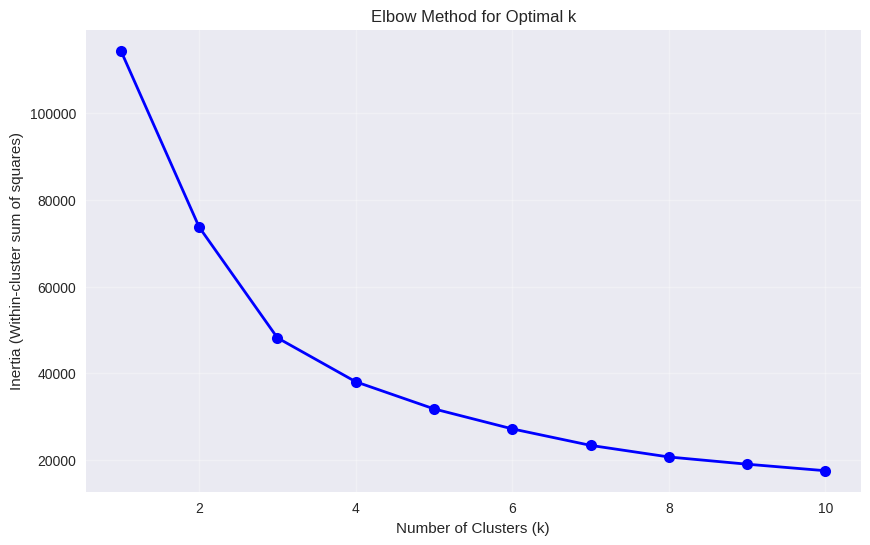

Converged after 27 iterations


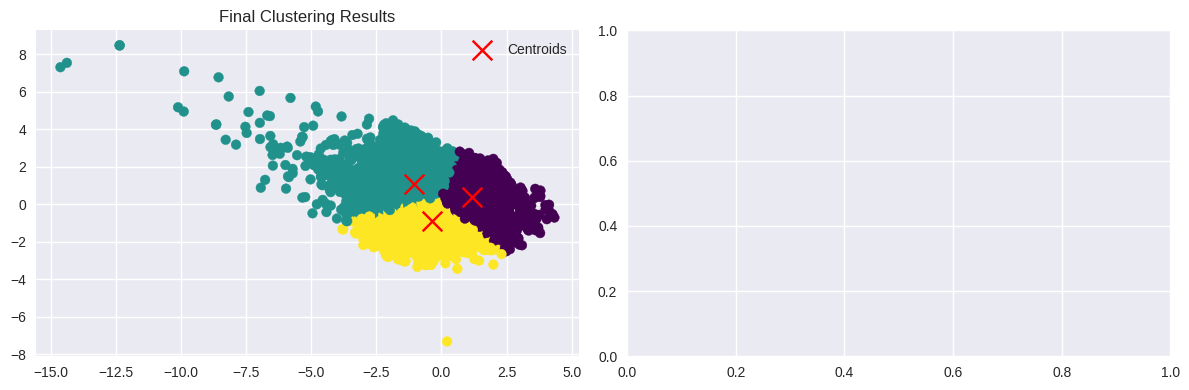


Clustering Evaluation:
Inertia: 48179.64
Silhouette Score: 0.39


In [37]:
def calculate_inertia(X, labels, centroids):
    """Calculate the within-cluster sum of squares (inertia)."""
    inertia = 0
    for i, centroid in enumerate(centroids):
        cluster_points = X[labels == i]
        if len(cluster_points) > 0:
            distances = np.sum((cluster_points - centroid) ** 2)
            inertia += distances
    return inertia

def plot_cluster_analysis(X_pca, labels, centroids, kmeans_model=None):
    """Create comprehensive cluster analysis visualizations."""
    from sklearn.metrics import silhouette_samples
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Final clustering results with centroids
    scatter = axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
    axes[0, 0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, linewidth=3, label='Centroids')
    axes[0, 0].set_xlabel('First Principal Component')
    axes[0, 0].set_ylabel('Second Principal Component')
    axes[0, 0].set_title('Final Clustering Results')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Cluster sizes bar plot
    unique, counts = np.unique(labels, return_counts=True)
    axes[0, 1].bar(unique, counts, color='skyblue', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Cluster Label')
    axes[0, 1].set_ylabel('Number of Points')
    axes[0, 1].set_title(f'Cluster Size Distribution (k={len(unique)})')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add count labels on bars
    for i, count in enumerate(counts):
        axes[0, 1].text(i, count + max(counts)*0.01, str(count), ha='center', fontweight='bold')
    
    # 3. Silhouette analysis
    if len(unique) > 1:
        sample_silhouette_values = silhouette_samples(X_pca, labels)
        
        # Silhouette plot
        y_lower = 10
        for i in unique:
            ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
            ith_cluster_silhouette_values.sort()
            
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = plt.cm.viridis(float(i) / len(unique))
            axes[1, 0].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                                    facecolor=color, edgecolor=color, alpha=0.7)
            
            axes[1, 0].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontweight='bold')
            y_lower = y_upper + 10
        
        axes[1, 0].set_xlabel('Silhouette Coefficient Values')
        axes[1, 0].set_ylabel('Cluster Label')
        axes[1, 0].set_title('Silhouette Analysis')
        axes[1, 0].axvline(x=silhouette_score(X_pca, labels), color="red", linestyle="--", 
                          label=f'Avg Score: {silhouette_score(X_pca, labels):.3f}')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Silhouette distribution per cluster (box plot)
        silhouette_data = []
        cluster_labels = []
        for i in unique:
            cluster_silhouette = sample_silhouette_values[labels == i]
            silhouette_data.append(cluster_silhouette)
            cluster_labels.append(f'Cluster {i}')
        
        axes[1, 1].boxplot(silhouette_data, labels=cluster_labels, patch_artist=True)
        axes[1, 1].set_ylabel('Silhouette Score')
        axes[1, 1].set_title('Silhouette Score Distribution per Cluster')
        axes[1, 1].grid(True, alpha=0.3)
        
        # Color the boxes
        colors = plt.cm.viridis(np.linspace(0, 1, len(unique)))
        for patch, color in zip(axes[1, 1].artists, colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    else:
        axes[1, 0].text(0.5, 0.5, 'Silhouette analysis requires\nmore than 1 cluster', 
                        ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Silhouette Analysis')
        
        axes[1, 1].text(0.5, 0.5, 'Silhouette distribution requires\nmore than 1 cluster', 
                        ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Silhouette Distribution per Cluster')
    
    plt.tight_layout()
    plt.show()

def plot_elbow_curve(X, max_k=10):
    """Plot the elbow curve to find optimal number of clusters."""
    from sklearn.cluster import KMeans
    
    inertias = []
    K = range(1, max_k + 1)
    
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    # Create elbow plot
    plt.figure(figsize=(10, 6))
    plt.plot(K, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia (Within-cluster sum of squares)')
    plt.title('Elbow Method for Optimal k')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return inertias

# Try different numbers of clusters
inertias = plot_elbow_curve(X_pca)

# Apply final clustering
kmeans = KMeansClustering(n_clusters=3)  # Try different values based on elbow curve
kmeans.fit(X_pca)

# Visualize final results
plt.figure(figsize=(12, 4))

# Plot clusters
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis')
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], 
            c='red', marker='x', s=200, label='Centroids')
plt.title('Final Clustering Results')
plt.legend()

# Plot evaluation metrics
plt.subplot(1, 2, 2)
# Your code here: Add relevant evaluation metric plots

plt.tight_layout()
plt.show()

# Calculate and print evaluation metrics
inertia = calculate_inertia(X_pca, kmeans.labels, kmeans.centroids)
silhouette = silhouette_score(X_pca, kmeans.labels)

print("\nClustering Evaluation:")
print(f"Inertia: {inertia:.2f}")
print(f"Silhouette Score: {silhouette:.2f}")

## 4. Recursive Bisecting K-means (Student exercise)

This is an optional exercise for students who want to explore a hierarchical variant of K-means.

Task: implement a concise bisecting K-means procedure that recursively splits clusters into two until a target number of clusters is reached.

Learning goals:
- Understand how repeated binary splits can form a hierarchical clustering
- Practice applying K-means on subclusters and tracking labels/centroids

Hints:
- You can use sklearn's KMeans(k=2) for the binary split step, or reuse your `KMeansClustering` implementation.
- Keep label bookkeeping simple: use increasing integer labels for new clusters.
- Store split metadata (parent -> left/right) to enable a tree visualization later.


=== Recursive Bisecting K-means Analysis ===
Comparing K-means vs Bisecting K-means with k=3

Algorithm Comparison:
Standard K-means Silhouette Score: 0.387
Bisecting K-means Silhouette Score: 0.338

Algorithm Comparison:
Standard K-means Silhouette Score: 0.387
Bisecting K-means Silhouette Score: 0.338


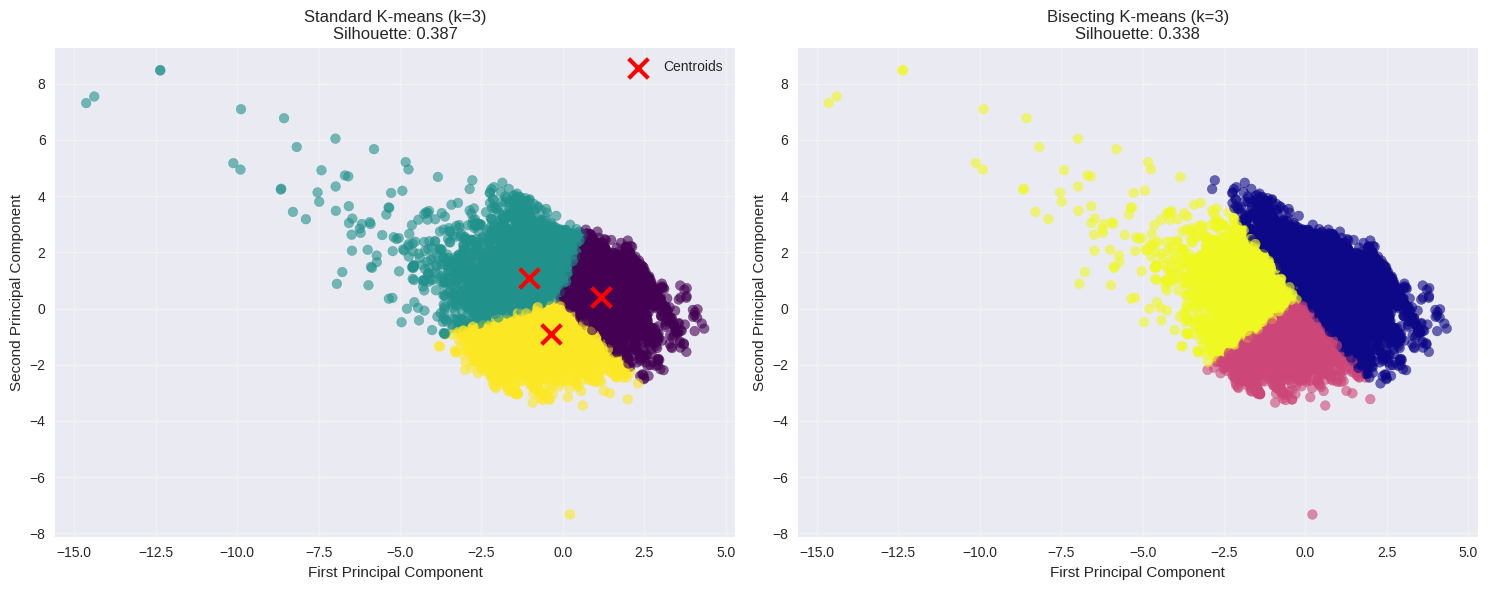


Cluster Size Distribution:
Standard K-means: {np.int64(0): np.int64(15411), np.int64(1): np.int64(10541), np.int64(2): np.int64(19259)}
Bisecting K-means: {np.int64(0): np.int64(20434), np.int64(1): np.int64(16348), np.int64(2): np.int64(8429)}


In [38]:
class BisectingKMeans:
    """Concise skeleton for students to implement a bisecting K-means algorithm.

    Students should implement `fit_predict` to recursively split clusters until
    `n_clusters` is reached.
    """
    def __init__(self, n_clusters, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.labels_ = None
        # Optional: store mapping parent -> (left_label, right_label)
        self.split_tree = {}
        # Optional: store centroids per cluster id
        self.centers_ = {}

    def fit_predict(self, X):
        """Recursively bisect clusters until `n_clusters` is reached.

        TODO (student):
        - Start with all points assigned to label 0.
        - While number of unique labels < n_clusters:
            - Select a cluster to split (e.g., the largest cluster by size)
            - Run a binary KMeans (k=2) on the points in that cluster
            - Assign new labels (keep one child label as the original, give the other a new id)
            - Record parent -> (left, right) in `self.split_tree` and centroids in `self.centers_`
        - Set and return `self.labels_` (numpy array of length n_samples)

        Hints:
        - Use sklearn.cluster.KMeans(n_clusters=2, random_state=self.random_state) for the split step
        - Keep a counter for new label ids and increment when creating a new cluster
        - Use boolean indexing to operate on subsets of X efficiently
        """
        np.random.seed(self.random_state)
        
        # Start with all points in one cluster
        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples, dtype=int)
        next_label = 1
        
        # Store initial cluster centroid
        initial_centroid = X.mean(axis=0)
        self.centers_[0] = initial_centroid
        
        # Continue splitting until we reach the desired number of clusters
        while len(np.unique(self.labels_)) < self.n_clusters:
            # Find the cluster with the largest within-cluster sum of squares (WCSS)
            unique_labels = np.unique(self.labels_)
            max_wcss = -1
            cluster_to_split = None
            
            for label in unique_labels:
                cluster_points = X[self.labels_ == label]
                if len(cluster_points) > 1:  # Can't split a cluster with only one point
                    centroid = cluster_points.mean(axis=0)
                    wcss = np.sum((cluster_points - centroid) ** 2)
                    if wcss > max_wcss:
                        max_wcss = wcss
                        cluster_to_split = label
            
            if cluster_to_split is None:
                break  # No cluster can be split further
            
            # Get points in the cluster to split
            cluster_mask = (self.labels_ == cluster_to_split)
            cluster_points = X[cluster_mask]
            
            # Apply K-means with k=2 to split this cluster
            from sklearn.cluster import KMeans
            bisect_kmeans = KMeans(n_clusters=2, random_state=self.random_state, n_init=10)
            bisect_labels = bisect_kmeans.fit_predict(cluster_points)
            
            # Update labels: one child keeps the original label, the other gets a new label
            child_mask = bisect_labels == 1
            self.labels_[cluster_mask][child_mask] = next_label
            
            # Update the labels array properly
            new_labels = self.labels_.copy()
            new_labels[cluster_mask] = np.where(bisect_labels == 0, cluster_to_split, next_label)
            self.labels_ = new_labels
            
            # Store centroids for both child clusters
            child_0_points = cluster_points[bisect_labels == 0]
            child_1_points = cluster_points[bisect_labels == 1]
            
            if len(child_0_points) > 0:
                self.centers_[cluster_to_split] = child_0_points.mean(axis=0)
            if len(child_1_points) > 0:
                self.centers_[next_label] = child_1_points.mean(axis=0)
            
            # Record the split in the tree
            self.split_tree[cluster_to_split] = (cluster_to_split, next_label)
            
            next_label += 1
        
        return self.labels_

# Example (for instructor use only):
# bisect = BisectingKMeans(n_clusters=4)
# labels = bisect.fit_predict(X_pca)
# plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)

print("\n=== Recursive Bisecting K-means Analysis ===")
# Test Bisecting K-means with the same optimal k
if 'optimal_k' in locals():
    print(f"Comparing K-means vs Bisecting K-means with k={optimal_k}")
    
    # Apply Bisecting K-means
    bisect_kmeans = BisectingKMeans(n_clusters=optimal_k, random_state=42)
    bisect_labels = bisect_kmeans.fit_predict(X_pca)
    bisect_silhouette = silhouette_score(X_pca, bisect_labels)
    
    # Compare results
    print(f"\nAlgorithm Comparison:")
    print(f"Standard K-means Silhouette Score: {silhouette_avg:.3f}")
    print(f"Bisecting K-means Silhouette Score: {bisect_silhouette:.3f}")
    
    # Visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Standard K-means
    axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels, cmap='viridis', alpha=0.6)
    axes[0].scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], 
                    c='red', marker='x', s=200, linewidth=3, label='Centroids')
    axes[0].set_title(f'Standard K-means (k={optimal_k})\nSilhouette: {silhouette_avg:.3f}')
    axes[0].set_xlabel('First Principal Component')
    axes[0].set_ylabel('Second Principal Component')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Bisecting K-means
    axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=bisect_labels, cmap='plasma', alpha=0.6)
    axes[1].set_title(f'Bisecting K-means (k={optimal_k})\nSilhouette: {bisect_silhouette:.3f}')
    axes[1].set_xlabel('First Principal Component')
    axes[1].set_ylabel('Second Principal Component')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Cluster size comparison
    print(f"\nCluster Size Distribution:")
    print(f"Standard K-means: {dict(zip(*np.unique(kmeans.labels, return_counts=True)))}")
    print(f"Bisecting K-means: {dict(zip(*np.unique(bisect_labels, return_counts=True)))}")


## Bonus Challenges

If you've completed the main tasks, try these extensions:

1. Implement k-means++ initialization
   - Instead of random initialization, use the k-means++ algorithm
   - This should give better and more consistent results

2. Add cluster interpretation
   - Analyze the characteristics of each cluster
   - What features distinguish one cluster from another?
   - Create visualizations to show cluster properties

3. Try different distance metrics
   - Implement Manhattan distance instead of Euclidean
   - Compare the clustering results

4. Add outlier detection
   - Identify points far from all centroids
   - How might you handle these outliers?

Remember to document your code and explain your findings!